# **Search between the objects in an image! (SBO Net)**

**Author:** Mehrdad Mohammadian

**GitHub:**  https://github.com/mehrdad-dev/SBO

**Date:** May 2022

## **Install and import libs**

yolov5: https://pytorch.org/hub/ultralytics_yolov5/

CLIP: https://github.com/openai/CLIP

In [ ]:
! pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt > /dev/null
! pip install git+https://github.com/openai/CLIP.git > /dev/null

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import numpy as np
import torch
import clip
import cv2
import os

%matplotlib inline

## **Object Detection**

In [ ]:
def objectDetection(img_path:str, model) -> list:
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    image_name = os.path.basename(img_path)
    image_name = image_name.split('.')[0]

    result = model(image)
    result.crop(save_dir=image_name)
    detectedObjects = result.render()[0]
    path = image_name + '/crops/**/*.jpg'    

    listOfObjects = []
    for filename in glob(path):
        obj = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
        listOfObjects.append(obj)     

    return listOfObjects, detectedObjects

## **Find Objects**

In [ ]:
def similarity_top(similarity_list:list, listOfObjects:list, N) -> tuple():
    results = zip(range(len(similarity_list)), similarity_list)
    results = sorted(results, key=lambda x: x[1], reverse=True)
    images = []
    scores=[]
    for index, score in results[:N]:
        scores.append(score)
        images.append(listOfObjects[index])

    return scores, images


def findObjects(listOfObjects:list, query:str, model, preprocess, device:str, N) -> tuple():
    objects = torch.stack([preprocess(Image.fromarray(im)) for im in listOfObjects]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(objects)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        text_features = model.encode_text(clip.tokenize(query).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Retrieve the description vector and the photo vectors
    # @: https://docs.python.org/3/whatsnew/3.5.html?highlight=operator#whatsnew-pep-465
    similarity = (text_features.cpu().numpy() @ image_features.cpu().numpy().T) * 100
    similarity = similarity[0]
    scores, images = similarity_top(similarity, listOfObjects, N=N)     

    return scores, images

## **Util Functions**

In [ ]:
def plotResults(scores:list, images:list, n):
    plt.figure(figsize=(20,5))
    for index, img in enumerate(images):
        plt.subplot(1,n, index+1)
        plt.imshow(img)
        plt.title(scores[index])
        plt.axis('off')
    plt.show();

## **Create Pipeline**

### Configs

In [ ]:
OBJDETECTIONMODEL = 'yolov5x6'
OBJDETECTIONREPO = 'ultralytics/yolov5'
FINDERMODEL = 'ViT-B/32'
DEVICE = 'cpu'
N = 5

### Define Models

In [ ]:
objectDetectorModel = torch.hub.load(OBJDETECTIONREPO, OBJDETECTIONMODEL);
objectFinderModel , preProcess = clip.load(FINDERMODEL, device=DEVICE);
# Available Models:
# ['RN50',
#  'RN101',
#  'RN50x4',
#  'RN50x16',
#  'RN50x64',
#  'ViT-B/32',
#  'ViT-B/16',
#  'ViT-L/14',
#  'ViT-L/14@336px']

### Final Step

In [ ]:
def pipeline(image, query):
    listOfObjects, detectedObjects = objectDetection(image, objectDetectorModel)
    scores, images = findObjects(listOfObjects, query, objectFinderModel, preProcess, DEVICE, N)
    plt.figure(figsize=(20,5))
    plt.axis('off')
    plt.imshow(detectedObjects)
    plotResults(scores, images, N)

## **Now, Test on your image!**

Saved 1 image to 1
Saved results to 1



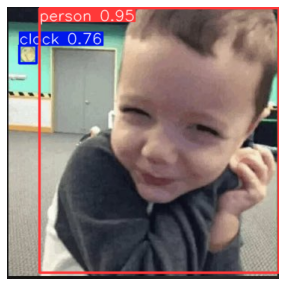

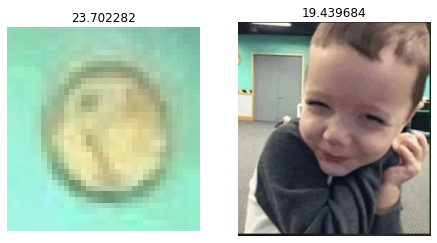

In [ ]:
pipeline('/content/1.jpg', 'clock')

Saved 1 image to 2
Saved results to 2



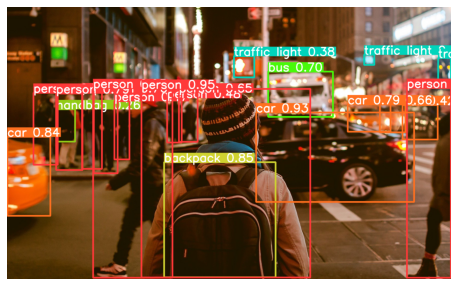

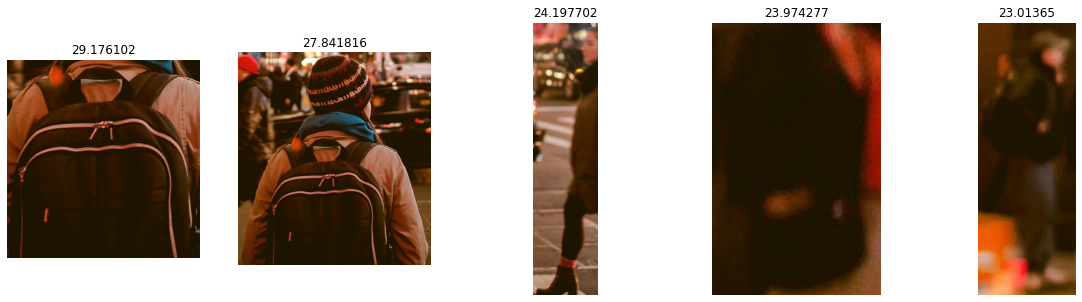

In [ ]:
pipeline('/content/2.jpg', 'black backpack')

Saved 1 image to 3
Saved results to 3



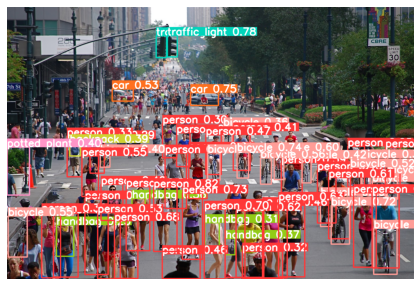

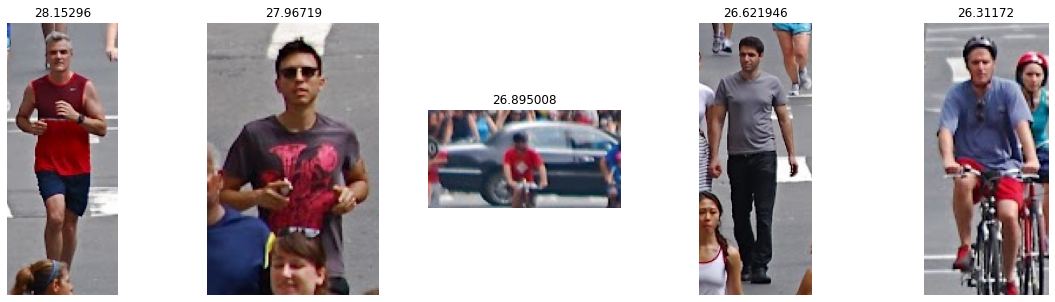

In [ ]:
pipeline('/content/3.jpg', 'man with a red shirt')

Saved 1 image to 3
Saved results to 3



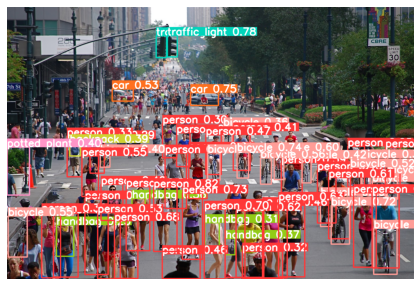

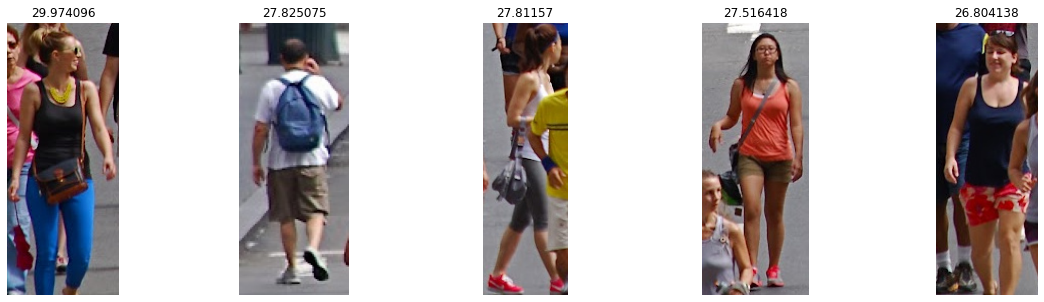

In [ ]:
pipeline('/content/3.jpg', 'woman with blue pants')

Saved 1 image to 5
Saved results to 5



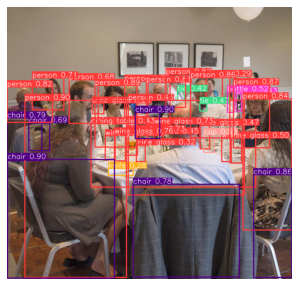

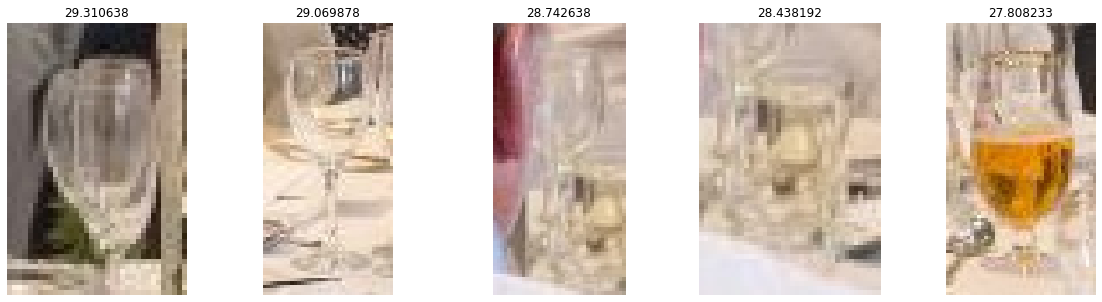

In [ ]:
pipeline('/content/5.jpg', 'wine glass')

Saved 1 image to 6
Saved results to 6



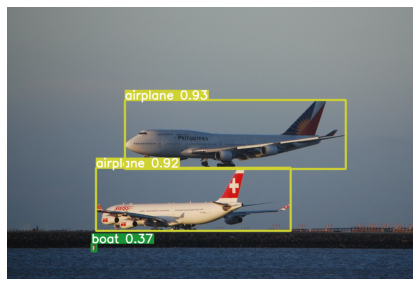

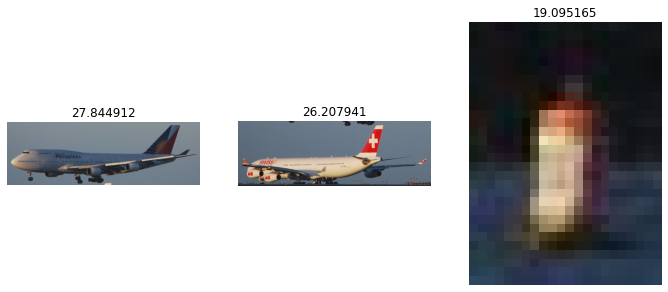

In [ ]:
pipeline('/content/6.jpg', 'a big gray airplane')

Saved 1 image to 4
Saved results to 4



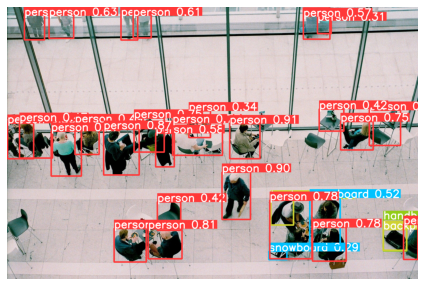

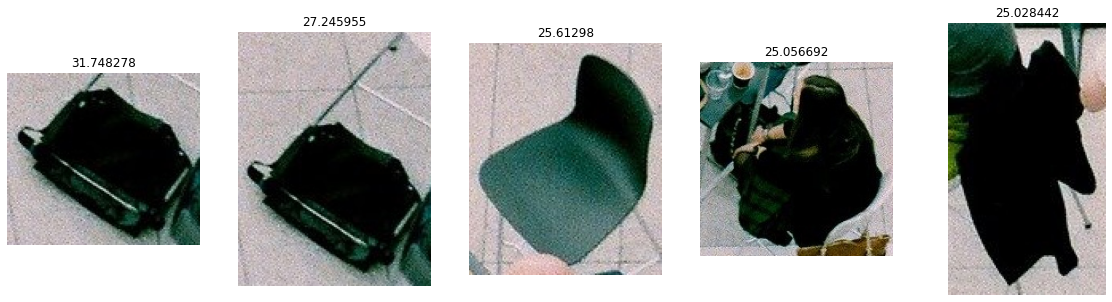

In [ ]:
pipeline('/content/4.jpg', 'black bag')